In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['text.usetex'] = True
sns.set_style('darkgrid')

from matplotlib.pyplot import Axes
from typing import Literal
from keras import optimizers
from keras import losses
from keras import metrics

from src.models import CustomFFNN
from src.data_import import load_data
from src.analytic_potential import get_C

2024-11-13 13:46:46.322648: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 13:46:46.484318: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 13:46:46.754892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-13 13:46:46.933953: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-13 13:46:46.986638: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 13:46:47.300105: I tensorflow/core/platform/cpu_feature_gu

# Task 2.2 - Naive Model approach

In [2]:
def get_naive_dataset(data: tuple[tf.Tensor, tf.Tensor, tf.Tensor]) -> tuple[tf.Tensor, tf.Tensor]:
    F, P, _ = data
    C = get_C(F)
    features = tf.stack([
        C[:, 0, 0], 
        C[:, 1, 1],
        C[:, 2, 2],
        C[:, 0, 1],
        C[:, 0, 2],
        C[:, 1, 2],
    ], axis=1)
    labels = tf.reshape(P, (-1, 9))
    return features, labels


## Load Dataset

In [3]:
data_path = os.path.abspath(os.path.join('calibration', 'biaxial.txt'))
data = load_data(data_path)
features, labels = get_naive_dataset(data)

## Model Initialization and Training

In [4]:
naive_model = CustomFFNN(
    input_size=6, 
    hidden_sizes=[32, 32, 32, 9],
    activations=['softplus', 'softplus', 'softplus', 'linear']
)
naive_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.MeanSquaredError()
)
h = naive_model.fit(features, labels, batch_size=16, validation_split=0.2, epochs=2000, verbose=0)
loss = h.history['loss']
val_loss = h.history['val_loss']

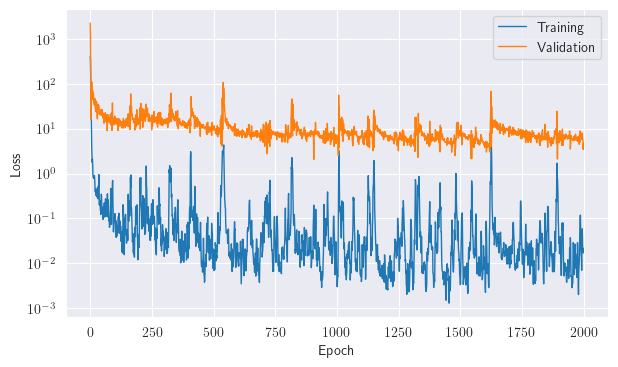

In [14]:
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(loss, lw=1, label='Training')
line, = ax.plot(val_loss, lw=1, label='Validation')
ax.set_yscale('log')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend()
plt.show()

## Model Evaluation

In [ ]:
predictions = naive_model.predict(features)

mets = [metrics.R2Score() for _ in range(labels.shape[1])]
for i in range(labels.shape[1]):  # Iterate over each of the 9 features/targets
    mets[i].update_state(tf.expand_dims(labels[:, i], -1), tf.expand_dims(predictions[:, i], -1))

# Now, get the R² score for each target (feature) separately
r2_scores = [metric.result().numpy() for metric in mets]

print("R² Scores for each feature:", r2_scores)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
R² Scores for each feature: [0.9986188, 0.0, 0.0, 0.0, 0.9983383, 0.0, 0.0, 0.0, -331338.0]


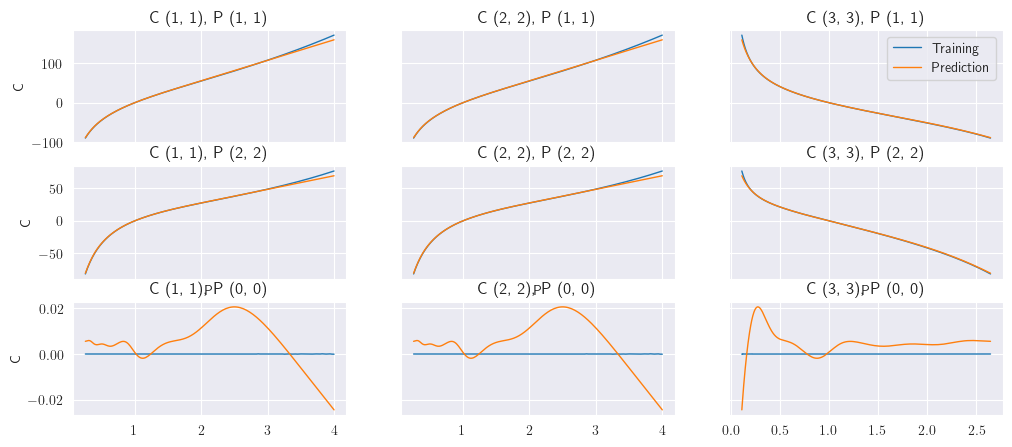

In [ ]:
fig, axs = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(12, 8))

# iterate over features
for i_C in range(3):

    # iterate over labels
    for ax_idx, i_P in enumerate([0, 4, 8]):
        ax: Axes = axs[ax_idx, i_C]
        line, = ax.plot(features[:, i_C], labels[:, i_P], lw=1, label='Training')
        line, = ax.plot(features[:, i_C], predictions[:, i_P], lw=1, label='Prediction')
        true_P_idx = (i_P+1) % 3
        true_C_idx = i_C + 1
        ax.set_title(f'C ({true_C_idx}, {true_C_idx}), P ({true_P_idx}, {true_P_idx})')

        if i_C == 2 and i_P == 0:
            ax.legend()
        
        if ax_idx == 1:
            ax.set_xlabel(f'P')
        if i_C == 0:
            ax.set_ylabel('C')

plt.show()